In [ ]:
import json
from IPython.display import display, Javascript
from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode

def render_episode(episode: RecordEpisode) -> None:
    data = json.dumps(episode.serialize_episode_data(), separators=(",", ":"))
    display(Javascript(f"""
var iframe = document.createElement('iframe');
iframe.src = 'https://s3vis.lux-ai.org/#/kaggle';
iframe.width = '100%';
iframe.scrolling = 'no';

iframe.addEventListener('load', event => {{
    event.target.contentWindow.postMessage({data}, 'https://s3vis.lux-ai.org');
}});

new ResizeObserver(entries => {{
    for (const entry of entries) {{
        entry.target.height = `${{Math.round(320 + 0.3 * entry.contentRect.width)}}px`;
    }}
}}).observe(iframe);

element.append(iframe);
    """))

def evaluate_agents(agent_1_cls, agent_2_cls, seed=42, games_to_play=3, replay_save_dir="replays", render=True):
    env = RecordEpisode(
        LuxAIS3GymEnv(numpy_output=True), save_on_close=True, save_on_reset=True, save_dir=replay_save_dir
    )
    obs, info = env.reset(seed=seed)
    total_wins = np.zeros((2))
    for i in range(games_to_play):
        obs, info = env.reset()
        env_cfg = info["params"] # only contains observable game parameters
        player_0 = agent_1_cls("player_0", env_cfg)
        player_1 = agent_2_cls("player_1", env_cfg)
    
        # main game loop
        game_done = False
        step = 0
        print(f"Running game {i}")
        while not game_done:
            actions = dict()
            for agent in [player_0, player_1]:
                actions[agent.player] = agent.act(step=step, obs=obs[agent.player])
            obs, reward, terminated, truncated, info = env.step(actions)
            # info["state"] is the environment state object, you can inspect/play around with it to e.g. print
            # unobservable game data that agents can't see
            dones = {k: terminated[k] | truncated[k] for k in terminated}
            if dones["player_0"] or dones["player_1"]:
                game_done = True
            step += 1
        total_wins += np.array([reward["player_0"],reward["player_1"]])
        if render:
            render_episode(env)
    print(total_wins/games_to_play)
    env.close() # free up resources and save final replay

In [ ]:
from lux.utils import direction_to
import numpy as np
class Agent():
    def __init__(self, player: str, env_cfg) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        np.random.seed(0)
        self.env_cfg = env_cfg
        
        self.unit_explore_locations = dict()
        self.relic_node_positions = []
        self.discovered_relic_nodes_ids = set()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit. 
        
        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        unit_mask = np.array(obs["units_mask"][self.team_id]) # shape (max_units, )
        unit_positions = np.array(obs["units"]["position"][self.team_id]) # shape (max_units, 2)
        unit_energys = np.array(obs["units"]["energy"][self.team_id]) # shape (max_units, 1)
        observed_relic_node_positions = np.array(obs["relic_nodes"]) # shape (max_relic_nodes, 2)
        observed_relic_nodes_mask = np.array(obs["relic_nodes_mask"]) # shape (max_relic_nodes, )
        team_points = np.array(obs["team_points"]) # points of each team, team_points[self.team_id] is the points of the your team
        # ids of units you can control at this timestep
        available_unit_ids = np.where(unit_mask)[0]
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)


        # visible relic nodes
        visible_relic_node_ids = set(np.where(observed_relic_nodes_mask)[0])
        # save any new relic nodes that we discover for the rest of the game.
        for id in visible_relic_node_ids:
            if id not in self.discovered_relic_nodes_ids:
                self.discovered_relic_nodes_ids.add(id)
                self.relic_node_positions.append(observed_relic_node_positions[id])

        # unit ids range from 0 to max_units - 1
        for unit_id in available_unit_ids:
            unit_pos = unit_positions[unit_id]
            # if we found at least one relic node
            if len(self.relic_node_positions) > 0:
                nearest_relic_node_position = self.relic_node_positions[0]
                manhattan_distance = abs(unit_pos[0] - nearest_relic_node_position[0]) + abs(unit_pos[1] - nearest_relic_node_position[1])
                
                # if close to the relic node we want to move randomly around it and hope to gain points
                if manhattan_distance <= 4:
                    random_direction = np.random.randint(0, 5)
                    actions[unit_id] = [random_direction, 0, 0]
                else:
                    # otherwise we want to move towards the relic node
                    actions[unit_id] = [direction_to(unit_pos, nearest_relic_node_position), 0, 0]
            # every 20 steps or if a unit doesn't have an assigned location to explore
            else:
                if step % 20 == 0 or unit_id not in self.unit_explore_locations:
                    # pick a random location on the map for the unit to explore
                    rand_loc = (np.random.randint(0, self.env_cfg["map_width"]), np.random.randint(0, self.env_cfg["map_height"]))
                    self.unit_explore_locations[unit_id] = rand_loc
                # using the direction_to tool we can generate a direction that makes the unit move to the saved location
                # note that the first index of each unit's action represents the type of action. See specs for more details
                actions[unit_id] = [direction_to(unit_pos, self.unit_explore_locations[unit_id]), 0, 0]
        return actions

In [ ]:
#%%writefile agent/agent.py
from lux.utils import direction_to
import numpy as np
import random


class Agent2():
    def __init__(self, player: str, env_cfg) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        np.random.seed(0)
        self.env_cfg = env_cfg
        if self.player=="player_0":
            self.start_pos = [0,0]
            self.pnum = 0
        else:
            self.start_pos = [self.env_cfg["map_width"], self.env_cfg["map_height"]]
            self.pnum = 1
        self.unit_explore_locations = dict()
        self.relic_node_positions = []
        self.discovered_relic_nodes_ids = set()

        self.n_units = self.env_cfg["max_units"]
        self.range = self.env_cfg["unit_sensor_range"]
        self.width = self.env_cfg["map_width"]
        self.height = self.env_cfg["map_height"]
        self.explore_targets = [(self.range+1, self.height-self.range-1), 
                                (self.width-self.range-1, self.range+1), 
                                (self.width-self.start_pos[0]+self.range*(-1)**self.pnum, self.height-self.start_pos[0]+self.range*(-1)**self.pnum)
                               ]
        self.relic_targets = []
        self.explore_targets = []
        self.unit_has_target = -np.ones((self.n_units)) # -1=no target; 0=explore target; 1=relic target; 2=on relic
        self.unit_targets = dict(zip(range(0,self.n_units), np.zeros(self.n_units)))
        self.prev_points = 0
        self.prev_points_increase = 0
        self.prev_actions = None

    def direction_to_change(self, direction):
        if direction==0:
            change = [0,0]
        if direction==1:
            change = [0,-1]
        if direction==2:
            change = [1,0]
        if direction==3:
            change = [0,1]
        if direction==4:
            change = [-1,0]
        return np.array(change)
    
    def get_moves(self, obs, unit_id, unit_pos):
        prev_pos = [unit_pos[0] - self.direction_to_change(self.prev_actions[unit_id][0])[0], unit_pos[1] - self.direction_to_change(self.prev_actions[unit_id][0])[1]]
        new_pos = [[unit_pos[0], unit_pos[1]-1],
                  [unit_pos[0]+1, unit_pos[1]],
                  [unit_pos[0], unit_pos[1]+1],
                  [unit_pos[0]-1, unit_pos[1]]]
        moves = [0]
        for ii, pos in enumerate(new_pos):
            if pos[0]<0 or pos[1]<0 or pos[0]>=self.width or pos[1]>=self.height or (pos[0]==prev_pos[0] and pos[1]==prev_pos[1]) or obs["map_features"]["tile_type"][pos[0], pos[1]]==2 :
                pass
            else:
                moves.append(direction_to(unit_pos, pos))
        return moves
        
    # moves around asteroids
    def move_obstacle_avoid(self, obs, unit_id, unit_pos, direction):
        moves = self.get_moves(obs, unit_id, unit_pos)
        if direction in moves:
            return direction
        elif moves:
            return random.choice(moves)
        else:
            return 0
            
    def relic_to_targets(self, pos):
        targets = []
        for i in range(-2,3,1):
            for j in range(-2,3,1):
                targets.append(np.array([pos[0]+i, pos[1]+j]))
        return targets
        
    def act(self, step: int, obs, remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit. 
        
        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        unit_mask = np.array(obs["units_mask"][self.team_id]) # shape (max_units, )
        unit_positions = np.array(obs["units"]["position"][self.team_id]) # shape (max_units, 2)
        unit_energys = np.array(obs["units"]["energy"][self.team_id]) # shape (max_units, 1)
        observed_relic_node_positions = np.array(obs["relic_nodes"]) # shape (max_relic_nodes, 2)
        observed_relic_nodes_mask = np.array(obs["relic_nodes_mask"]) # shape (max_relic_nodes, )
        team_points = np.array(obs["team_points"]) # points of each team, team_points[self.team_id] is the points of the your team
        increase = team_points[self.team_id]-self.prev_points
        # ids of units you can control at this timestep
        available_unit_ids = np.where(unit_mask)[0]
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)

        #print(obs)
        # visible relic nodes
        visible_relic_node_ids = set(np.where(observed_relic_nodes_mask)[0])
        # save any new relic nodes that we discover for the rest of the game.
        for id in visible_relic_node_ids:
            if id not in self.discovered_relic_nodes_ids:
                self.discovered_relic_nodes_ids.add(id)
                self.relic_node_positions.append(observed_relic_node_positions[id])
                self.relic_targets.extend(self.relic_to_targets(observed_relic_node_positions[id]))
        #print(self.relic_targets)
        # unit ids range from 0 to max_units - 1
        for unit_id in available_unit_ids:
            unit_pos = unit_positions[unit_id]
            if self.unit_has_target[unit_id]!=-1 and self.unit_has_target[unit_id]!=2 and unit_pos[0]==self.unit_targets[unit_id][0] and unit_pos[1]==self.unit_targets[unit_id][1]:
                if increase>self.prev_points_increase:
                    self.unit_has_target[unit_id]=2
                else:
                    self.unit_has_target[unit_id]=-1
            if self.unit_has_target[unit_id]==-1:
                # set target of unit to relic tile
                if self.relic_targets:
                    rand = np.random.randint(0,len(self.relic_targets)) ### closest relic target not random
                    dist = np.sum(np.abs(np.array(self.relic_targets)-unit_pos),axis=1)
                    target = self.relic_targets.pop(np.argmin(dist))
                    self.unit_has_target[unit_id] = 1
                
                # every 20 steps or if a unit doesn't have an assigned location to explore
                else:
                    if step % 20 == 0 or unit_id not in self.unit_explore_locations:
                        if self.explore_targets:
                            target = self.explore_targets.pop(0)
                        else:
                            # pick a random location on the map for the unit to explore
                            rand_loc = (np.random.randint(0, self.env_cfg["map_width"]), np.random.randint(0, self.env_cfg["map_height"]))
                            target = rand_loc
                        self.unit_has_target[unit_id] = 0
                
                self.unit_targets[unit_id] = target
            #print(self.unit_has_target)
            direction = self.move_obstacle_avoid(obs, unit_id, unit_pos, direction_to(unit_pos, self.unit_targets[unit_id]))
            actions[unit_id] = [direction, 0, 0]
        #print(self.unit_has_target, "\n", self.unit_targets, "\n",)
        self.prev_points = team_points[self.team_id]
        self.prev_points_increase = increase
        self.prev_actions = actions

        return actions

In [ ]:

class RelicMap():
    '''
    Relic map keeps track of locations of relic positions, known fragments, disproven fragments and possible fragments.
    It also stores the current status for each unit in relation to it's position and fragment locations
    map: 24 x 24 game map
        -1 = unknown
        0 = disproven fragment
        1 = possible fragment
        2 = known fragment
        3 = known and occupied
    '''
    def __init__(self, n_units):
        self.map_knowns = np.zeros((24,24))
        self.map_possibles = np.zeros((24,24))
        self.map_confidence = np.zeros((24,24))#(5/9)*np.ones((24,24))
        self.unit_status = np.zeros((n_units))

    def reset(self):
        pass
        #self.map[self.map==3] = 2
        #poss = knowns = np.transpose((self.map_confidence<=0.75).nonzero())
        #poss2 = knowns = np.transpose((self.map_confidence>=0.25).nonzero())
        #for p in poss:
        #    if p.tolist() in poss2.tolist():
        #        self.map_visited[p] = 0
                
    def new_relic(self, pos):
        #patch = self.map[pos[0]-2:pos[0]+3,pos[1]-2:pos[1]+3]
        #patch[patch==-1] = 1
        for x in range(-2,3,1):
            for y in range(-2,3,1):
                if pos[0]+x>=0 and pos[0]+x<=23 and pos[1]+y>=0 and pos[1]+y<=23 and self.map_knowns[pos[0],pos[1]]!=1:
                    if self.map_knowns[pos[0]+x,pos[1]+y] !=1:
                        self.map_possibles[pos[0]+x,pos[1]+y] = 1
                        #self.map_possibles[abs(pos[1]+y-23),abs(pos[0]+x-23)] = 1
                        self.map_confidence[pos[0]+x,pos[1]+y] = 5/9
                        #self.map_confidence[abs(pos[1]+y-23),abs(pos[0]+x-23)] = 5/9
        
        #self.map_confidence[pos[0]-2:pos[0]+3,pos[1]-2:pos[1]+3] = 9/25
        #self.map_confidence[abs(pos[1]-23)-2:abs(pos[1]-23)+3,abs(pos[0]-23)-2:abs(pos[0]-23)+3] = 9/25

    def get_fragments(self, start, own=False):
        knowns = np.transpose((self.map_knowns==1).nonzero())
        if not own:
            return knowns.tolist()
        own = []
        for k in knowns:
            if abs(k[0]-start[0])+abs(k[0]-start[1])<24:
                own.append(k)
        return own

    def get_possibles(self, start, own=False):
        poss = np.transpose((self.map_possibles==1).nonzero())
        if not own:
            return poss
        own = []
        for k in poss.tolist():
            if abs(k[0]-start[0])+abs(k[0]-start[1])<24:
                own.append(k)
        return own

    def move_away(self, pos):
        moves = [1,2,3,4]
        options = np.array([[pos[0],pos[1]-1],[pos[0]+1,pos[1]],[pos[0],pos[1]+1],[pos[0]-1,pos[1]]])
        for ii, option in enumerate(options):
            if np.max(option)>23 or np.min(option)<0:
                continue
            if self.map_knowns[option[0],option[1]]==1:
                return moves[ii]
            if self.map_possibles[option[0],option[1]]==0 and self.map_knowns[option[0],option[1]]==0:
                return moves[ii]
        return np.random.randint(1,5)
        
    def step(self, unit_positions, increase):
        S = []
        F = []
        ones = 0
        rest = []
        check_knowns = self.map_knowns.copy()
        check_possibles = self.map_possibles.copy()
        for unit in unit_positions:
            if check_knowns[unit[0],unit[1]]==1:
                ones += 1
                check_knowns[unit[0],unit[1]]=0
            if check_possibles[unit[0],unit[1]]==1:
                check_possibles[unit[0],unit[1]]=0
                S.append(unit)
        r1 = increase-ones
        r2 = 0
        c_sum = 0
        if r1<=0:
            for unit in S:
                self.map_possibles[unit[0],unit[1]]=0
                self.map_confidence[unit[0],unit[1]]=0
        else:
            for unit in S:
                self.map_confidence[unit[0],unit[1]]=r1/len(S)#self.map_confidence[unit[0],unit[1]]*()
                r2 += self.map_confidence[unit[0],unit[1]]
            for unit in S:
                #self.map_confidence[unit[0],unit[1]] = self.map_confidence[unit[0],unit[1]]*(r1/r2)
                if self.map_confidence[unit[0],unit[1]]==0.0:
                    self.map_confidence[unit[0],unit[1]]=0
                    self.map_possibles[unit[0],unit[1]]=0
                    #self.map_possibles[abs(unit[1]-23),abs(unit[0]-23)]=0
                if self.map_confidence[unit[0],unit[1]]==1.0:
                    self.map_confidence[unit[0],unit[1]]=1
                    self.map_possibles[unit[0],unit[1]]=0
                    self.map_knowns[unit[0],unit[1]]=1
                    self.map_possibles[abs(unit[1]-23),abs(unit[0]-23)]=0
                    self.map_knowns[abs(unit[1]-23),abs(unit[0]-23)]=1
                    
            
            
            
                
        

In [ ]:
class TileMap():
    def __init__(self):
        self.map = -np.ones((24,24))
        self.known = np.zeros((24,24))
    def update(self, current):
        shift = self.check_shift(current)
        self.map[current!=-1] = current[current!=-1]
        self.known[self.map!=-1] = 1
        self.mirror()
        return shift
        
    def mirror(self):
        self.map[::-1,::-1].T[self.map!=-1] = self.map[self.map!=-1]
        self.known[::-1,::-1].T[self.known==1] = self.known[self.known==1]
        
    def check_shift(self, current):
        if np.sum(1*((self.known*self.map)[current!=-1]!=(self.known*current)[current!=-1]))>0:
            map1 = (self.known*self.map)[0:23,1:24]
            map2 = (self.known*self.map)[1:24,0:23]
            mapcp = self.map.copy()
            self.map = -np.ones((24,24))
            current1 = (self.known*current)[1:24,0:23]
            current2 = (self.known*current)[0:23,1:24]
            new_known = np.zeros((24,24))
            if np.sum(1*(map1[current1!=-1]!=current1[current1!=-1]))>np.sum(1*(map2[current2!=-1]!=current2[current2!=-1])):
                self.map[0:23,1:24] = mapcp[1:24,0:23]
                new_known[0:23,1:24] = self.known[1:24,0:23]
                self.known = new_known
            else:
                self.map[1:24,0:23] = mapcp[0:23,1:24]
                new_known[1:24,0:23] = self.known[0:23,1:24]
                self.known = new_known
            return 1
        else:
            return 0
            

In [ ]:
a = np.random.randint(1,3,(5,5))
b = np.random.randint(1,3,(5,5))
print(1*(a==b))

In [75]:
class EnergyMap():
    def __init__(self):
        self.map = np.full((24,24),1.5)
        self.known = np.zeros((24,24))
        self.energy_maps = []
        self.positions = []
        for x in range(24):
            for y in range(24):
                if x+y>23:
                    break
                self.energy_maps.append(self.calculate_energy([x,y]))
                self.positions.append([x,y])
    

    def energy_function(self, d):
        return np.sin(1.2*d+1)*4
    
    def calculate_energy(self, pos):
        pos2 = [abs(pos[1]-23),abs(pos[0]-23)]
        a = np.stack((np.repeat(np.arange(24),24,axis=0).reshape((24,24)),
                      np.repeat(np.arange(24),24,axis=0).reshape((24,24)).T),axis=2)
        e1 = self.energy_function(np.linalg.norm(a-np.array(pos),axis=2))
        e2 = self.energy_function(np.linalg.norm(a-np.array(pos2),axis=2))
        e = np.array([e1,e2])
        e = np.where(
                e.mean() < 0.25,
                e + (0.25 - e.mean()),
                e,
            )
        e = np.round(e.sum(0)).astype(np.int16)+1
        e = np.clip(
                e, -10, 10
            )
        return e.astype(float)
    
    def update(self, current):
        mask = 1*(current!=-1)
        shift = self.check_shift(current)
        if shift:
            for m in self.energy_maps:
                if (mask*current==mask*m).all():
                    self.map = m
                    break
                    
        
        
    def check_shift(self, current):
        if np.sum(1*(self.map[current!=-1]!=current[current!=-1]))>0:
            return 1
        else:
            return 0

In [76]:
def reconstruct_path(came_from, came_from_flag, current):
    total_path = [current]
    while came_from_flag[current[0], current[1]]==1:
        current = [int(came_from[current[0],current[1],0]),int(came_from[current[0],current[1],1])]
        total_path.insert(0,current)
    return total_path

def h(start, goal, move_cost):
    steps = abs(goal[0]-start[0]) + abs(goal[1]-start[0])
    return steps*move_cost

def get_neighbors(node):
    neighbors = [[node[0],node[1]-1],
                [node[0]+1,node[1]],
                [node[0],node[1]+1],
                [node[0]-1,node[1]],]
    neighbors = np.unique(np.clip(np.array(neighbors),0,23),axis=0)
    neighbors = neighbors[(neighbors[:,:]!=np.array(node)).any(1)]
    return neighbors.tolist()
    
def find_lowest(f_score, open_set):
    index = None
    lowest = 1e20
    for ii, node in enumerate(open_set):
        if f_score[node[0],node[1]]<lowest:
            index = ii
            lowest = f_score[node[0],node[1]]
    return index
    
def a_star(start, goal, tile_map, energy_map, move_cost, nebula_drain):
    
    d = np.full((24,24), move_cost)
    d += -energy_map + np.full((24,24),np.max(energy_map))
    d[tile_map==1] = d[tile_map==1] + nebula_drain
    d[tile_map==2] = d[tile_map==2] + 1e6
    d[tile_map==-1] = d[tile_map==-1] 
    
    open_set = [start]
    came_from = -np.ones((24,24,2))
    came_from_flag = np.zeros((24,24))
    #came_from_flag[start[0], start[1]] = 1
    
    g_score = np.full((24,24),np.inf)
    g_score[start[0],start[1]] = 0
    
    f_score = np.full((24,24),np.inf)
    f_score[start[0],start[1]] = h(start, goal, move_cost)

    while open_set:
        lowest = find_lowest(f_score, open_set)
        current = open_set.pop(lowest)
        #print(current)
        if current[0]==goal[0] and current[1]==goal[1]:
            return reconstruct_path(came_from, came_from_flag, current), g_score[current[0], current[1]]
        for neighbor in get_neighbors(current):
            temp_g_score = g_score[current[0],current[1]] + d[neighbor[0],neighbor[1]]
            if temp_g_score<g_score[neighbor[0],neighbor[1]]:
                came_from[neighbor[0],neighbor[1],0] = current[0]
                came_from[neighbor[0],neighbor[1],1] = current[1]
                came_from_flag[neighbor[0],neighbor[1]] = 1
                g_score[neighbor[0],neighbor[1]] = temp_g_score
                f_score[neighbor[0],neighbor[1]] = temp_g_score + h(neighbor,goal,move_cost)
                if neighbor not in open_set:
                    open_set.append(neighbor)
    #print("Error in a*")
    #print(start, goal)
    #plt.imshow(tile_map)
    return [[0,0]], 1e10 

1
1


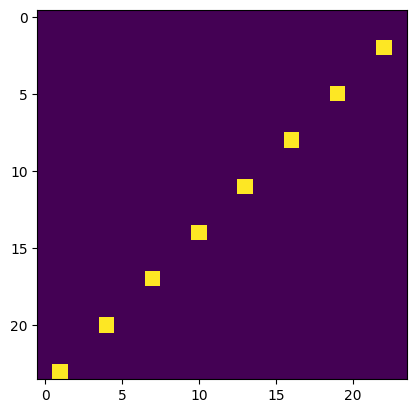

In [77]:
rnge = np.random.randint(1,5)
print(rnge)
p=np.random.randint(0,2)
print(p)
explore_t = [[i,abs(i-23+rnge)] for i in range(23-rnge+1)]
if p==1:
    explore_t = [[abs(t[1]-23),abs(t[0]-23)] for t in explore_t]
a = np.zeros((24,24))
for ii, t in enumerate(explore_t):
    if ii%(rnge+2)==0:
        a[t[0],t[1]] = 1
plt.imshow(a.T)

In [78]:
#%%writefile agent/agent.py
from my_agent.lux.utils import direction_to, direction_to_change
import matplotlib.pyplot as plt
#from agent.maps import RelicMap
import numpy as np
import random
np.set_printoptions(linewidth=200)

class Agent3():
    def __init__(self, player: str, env_cfg) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        np.random.seed(0)
        self.env_cfg = env_cfg
        if self.player=="player_0":
            self.start_pos = [0,0]
            self.pnum = 1
        else:
            self.start_pos = [23,23]
            self.pnum = 0
        self.unit_explore_locations = dict()
        self.relic_node_positions = []
        self.discovered_relic_nodes_ids = set()
        self.n_units = self.env_cfg["max_units"]
        self.relic_map = RelicMap(self.n_units)
        self.tile_map = TileMap()
        self.energy_map = EnergyMap()
        self.move_cost = 3.0
        self.nebula_drain = 5.0
        self.move_check = 0
        self.nebula_check = 0
        
        self.range = self.env_cfg["unit_sensor_range"]
        self.width = self.env_cfg["map_width"]
        self.height = self.env_cfg["map_height"]
        self.explore_targets = [(self.range+1, self.height-self.range-1), 
                                (self.width-self.range-1, self.range+1), 
                                (abs(self.width-self.start_pos[0])+self.range*(-1)**self.pnum, abs(self.height-self.start_pos[0])+self.range*(-1)**self.pnum)
                               ]
        self.relic_targets = []
        self.fragment_targets = []
        self.locked_relic_targets = []
        self.locked_fragment_targets = []
        self.fragment_locations = []
        self.occupied_fragments = []
        
        self.unit_has_target = -np.ones((self.n_units)) # -1=no target; 0=explore target; 1=relic target; 2=on relic
        self.unit_targets = dict(zip(range(0,self.n_units), np.zeros((self.n_units,2))))
        self.unit_path = dict(zip(range(0,self.n_units), [[] for i in range(0,self.n_units)]))
        self.unit_moved = np.zeros((self.n_units))
        self.prev_points = 0
        self.prev_points_increase = 0
        self.prev_actions = None
        self.previous_energys = 100*np.zeros((self.n_units))
        self.previous_positions = -np.ones((self.n_units,2))


    def get_explore(self):
        options = np.transpose((self.tile_map.map==-1).nonzero()).tolist()
        if options:
            return random.choice(options)
        else:
            return [0,0]
            
    def get_moves(self, obs, unit_id, unit_pos):
        prev_pos = [unit_pos[0] - direction_to_change(self.prev_actions[unit_id][0])[0], unit_pos[1] - direction_to_change(self.prev_actions[unit_id][0])[1]]
        new_pos = [[unit_pos[0], unit_pos[1]-1],
                  [unit_pos[0]+1, unit_pos[1]],
                  [unit_pos[0], unit_pos[1]+1],
                  [unit_pos[0]-1, unit_pos[1]]]
        moves = [0]
        for ii, pos in enumerate(new_pos):
            if pos[0]<0 or pos[1]<0 or pos[0]>=self.width or pos[1]>=self.height or (pos[0]==prev_pos[0] and pos[1]==prev_pos[1]) or obs["map_features"]["tile_type"][pos[0], pos[1]]==2 :
            #if pos[0]<0 or pos[1]<0 or pos[0]>23 or pos[1]>23 or obs["map_features"]["tile_type"][pos[0], pos[1]]==2:
                pass
            else:
                moves.append(direction_to(unit_pos, pos))
        #print(moves)
        return moves
        
    # moves around asteroids
    def move_obstacle_avoid(self, obs, unit_id, unit_pos, direction):
        moves = self.get_moves(obs, unit_id, unit_pos)
        if direction in moves:
            return direction
        elif moves:
            return random.choice(moves)
        else:
            return 0
            
    def relic_to_targets(self, pos):
        targets = []
        for i in range(-2,3,1):
            for j in range(-2,3,1):
                if pos[0]+i>=0 and pos[0]+i<=23 and pos[1]+j>=0 and pos[1]+j<=23:
                    new_target = np.array([pos[0]+i, pos[1]+j])
                    mirrored_target = np.abs(new_target-np.array([self.width, self.height]))
                    targets.append(new_target)
                    #targets.append(mirrored_target)
        return targets

    def sort_closest(self, targets, pos):
        distances = []
        for target in targets:
            _, d = a_star(pos, target, self.tile_map.map, np.zeros((24,24)), self.move_cost, 0)
            distances.append(d)
        return np.array(targets)[np.argsort(distances)].tolist()
        
    
    def reset(self):
        self.relic_map.reset()
        self.explore_targets = []
        self.unit_has_target = -np.ones((self.n_units)) # -1=no target; 0=explore target; 1=relic target; 2=on relic, 3=known fragment
        self.unit_targets = dict(zip(range(0,self.n_units), np.zeros((self.n_units,2))))
        self.unit_path = dict(zip(range(0,self.n_units), [[] for i in range(0,self.n_units)]))
        self.unit_moved = np.zeros((self.n_units))
        self.prev_points = 0
        self.prev_points_increase = 0
        self.prev_actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)
        self.prev_energys = 100*np.ones((self.n_units))
        self.previous_positions = -np.ones((self.n_units,2))
        self.fragment_locations = self.relic_map.get_fragments(self.start_pos, own=True)
        self.fragment_locations = self.sort_closest(self.fragment_locations, self.start_pos)
        self.possible_locations = self.relic_map.get_possibles(self.start_pos, own=True)
        self.possible_locations = self.sort_closest(self.possible_locations, self.start_pos)
        self.occupied_fragments = []
        #print(self.fragment_locations, self.possible_locations)
        # TODO target closet first
        targets = self.fragment_locations+self.possible_locations
        for unit in range(self.n_units):
            if unit<len(targets):
                target = targets[unit]
                self.unit_has_target[unit] = 1
                self.unit_targets[unit] = target
                self.unit_path[unit],_ = a_star(self.start_pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                self.unit_path[unit].pop(0)
            else:
                if self.fragment_locations:
                    target = self.fragment_locations[unit%len(self.fragment_locations)]
                    self.unit_targets[unit] = target
                    self.unit_has_target[unit] = 3
                    self.unit_targets[unit] = target
                    self.unit_path[unit],_ = a_star(self.start_pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                    self.unit_path[unit].pop(0)
                else:
                    target = self.get_explore()
                    self.unit_has_target= 0
                    self.unit_targets[unit] = target
                    self.unit_path[unit],_ = a_star(self.start_pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                    self.unit_path[unit].pop(0)
                    
        '''for unit in range(self.n_units):
            target = targets[unit%len(targets)]
            self.unit_has_target[unit] = 1
            self.unit_targets[unit] = target
            self.unit_path[unit],_ = a_star(self.start_pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
            self.unit_path[unit].pop(0)'''
        '''for unit, target in enumerate(self.fragment_locations + self.possible_locations):
            if unit<self.n_units:
                self.unit_has_target[unit] = 1
                self.unit_targets[unit] = target
                self.unit_path[unit],_ = a_star(self.start_pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                self.unit_path[unit].pop(0)'''
        #print(self.unit_targets, "\n", self.unit_path)

    def find_best_unit(self, goal, available_unit_ids, unit_positions):
        best_unit = 0
        best_pos = [-1,-1]
        best_dist = np.inf
        best_path = [goal]
        if len(available_unit_ids)>0:
            for ii, unit_id in enumerate(available_unit_ids):
                unit_pos = unit_positions[unit_id]
                path, dist = a_star(unit_pos, goal, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                if dist<best_dist:
                    best_dist = dist
                    best_path = path
                    best_unit = unit_id
                    best_pos = unit_pos
        return best_unit, best_path

    def compare_positions(self, pos1, pos2):
        return pos1[0]==pos2[0] and pos1[1]==pos2[1]

    def get_attack_targets(self):
        fragments = self.relic_map.get_fragments(self.start_pos)
        targets = []
        for frag in fragments:
            if self.tile_map.map[frag[0],frag[1]]!=2:
                if self.start_pos[0]==0:
                    if frag[0]+frag[1]>23:
                        targets.append(frag)
                else:
                    if frag[0]+frag[1]<23:
                        targets.append(frag)
        return targets

    def get_defend_targets(self, pos):
        #pos = self.occupied_fragments[unit%len(self.occupied_fragments)]
        surrounding = []
        distances = []
        for x in range(-2,3,1):
            for y in range(-2,3,1):
                if (x!=0 or y!=0) and pos[0]+x>=0 and pos[1]+y>=0 and pos[0]+x<=23 and pos[1]+y<=23:
                    new_pos = [pos[0]+x,pos[1]+y]
                    surrounding.append(new_pos)
                    distances.append(abs(new_pos[0]-abs(self.start_pos[0]-23))+abs(new_pos[1]-abs(self.start_pos[1]-23)))
        surrounding = np.array(surrounding)[np.argsort(np.array(distances))]
        surrounding = surrounding[:8].tolist()
        best_e = -np.inf
        best_pos = [-1,-1]
        for s in surrounding:
            if self.energy_map.map[s[0],s[1]]>best_e:
                best_e = self.energy_map.map[s[0],s[1]]
                best_pos = s
        return best_pos
        

    def get_enemy_targets(self, pos, enemy_positions):
        targets = []
        for dx in range(-self.range,self.range):
            for dy in range(-self.range,self.range):
                if [pos[0]+dx,pos[1]+dy] in enemy_positions:
                    targets.append([dx,dy])
        #print(pos, enemy_positions, targets)
        return targets
    def repath(self, unit_positions):
        for unit in range(self.n_units):
            pos = unit_positions[unit]
            if self.compare_positions(pos, [-1,-1]):
                pos = self.start_pos
            if self.unit_path[unit]:
                self.unit_path[unit],_ = a_star(pos, self.unit_targets[unit], self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                self.unit_path[unit].pop(0)
        
    def act(self, step: int, obs, remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit. 
        
        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        #print("Step: ", step)
        unit_mask = np.array(obs["units_mask"][self.team_id]) # shape (max_units, )
        unit_positions = np.array(obs["units"]["position"][self.team_id]) # shape (max_units, 2)
        enemy_positions = []
        for pos in np.array(obs["units"]["position"][abs(self.team_id-1)]).tolist():
            if pos[0]!=-1 and pos[1]!=-1:
                enemy_positions.append(pos)
        unit_energys = np.array(obs["units"]["energy"][self.team_id]) # shape (max_units, 1)
        observed_relic_node_positions = np.array(obs["relic_nodes"]) # shape (max_relic_nodes, 2)
        observed_relic_nodes_mask = np.array(obs["relic_nodes_mask"]) # shape (max_relic_nodes, )
        team_points = np.array(obs["team_points"]) # points of each team, team_points[self.team_id] is the points of the your team
        increase = team_points[self.team_id]-self.prev_points
        # ids of units you can control at this timestep
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)
        current_tile_map = obs["map_features"]["tile_type"]
        current_energy_map = obs["map_features"]["energy"]
        

        if step in [102,203,304,405]:
            self.reset()
            
        # visible relic nodes
        visible_relic_node_ids = set(np.where(observed_relic_nodes_mask)[0])
        # save any new relic nodes that we discover for the rest of the game.
        for ii in visible_relic_node_ids:
            if ii not in self.discovered_relic_nodes_ids:
                # explore units switch to relic collection
                self.relic_map.new_relic(observed_relic_node_positions[ii])
                self.unit_has_target[self.unit_has_target==0]=-1
                self.discovered_relic_nodes_ids.add(ii)
                self.discovered_relic_nodes_ids.add((ii+3)%6)
                self.relic_node_positions.append(observed_relic_node_positions[ii])
                self.relic_targets.extend(self.relic_to_targets(observed_relic_node_positions[ii]))
                # remove duplicates from relic targets
                self.relic_targets = list({array.tobytes(): array for array in np.array(self.relic_targets)}.values())
        # update maps
        available_unit_ids = np.where(unit_mask)[0].tolist()
        self.relic_map.step(unit_positions, increase)
        tile_shift = self.tile_map.update(current_tile_map)
        self.energy_map.update(current_energy_map)        

        # find out move cost
        if step>2 and not self.move_check and self.tile_map.map[unit_positions[0][0],unit_positions[0][1]]!=1 and self.unit_moved[0]:
            self.move_cost=self.previous_energys[0]-unit_energys[0]+self.energy_map.map[unit_positions[0][0],unit_positions[0][1]]
            print(self.move_cost)
            self.move_check=1
        # find out nebula drain
        if not self.nebula_check and self.move_check:
            for unit in available_unit_ids:
                if self.unit_moved[unit] and  self.tile_map.map[unit_positions[unit][0],unit_positions[unit][1]]==1:
                    self.nebula_check=1
                    self.nebula_drain = -(unit_energys[unit]-self.previous_energys[unit]-self.energy_map.map[unit_positions[unit][0],unit_positions[unit][1]]+self.move_cost)
                    print(unit_energys[unit], self.previous_energys[unit], self.energy_map.map[unit_positions[unit][0],unit_positions[unit][1]], self.move_cost)
                    print(step, unit, self.nebula_drain)
                    self.repath(unit_positions)
                    break
            
        if tile_shift:
            self.fragment_targets.extend(self.locked_fragment_targets)
            self.relic_targets.extend(self.locked_relic_targets)
            self.locked_relic_targets = []
            self.locked_fragment_targets = []
            self.repath(unit_positions)

        all_targets = self.fragment_targets + self.relic_targets + self.explore_targets
        release_count = len(all_targets)
        for unit in available_unit_ids.copy():
            pos = unit_positions[unit]
            #print("before ", pos, unit, self.unit_has_target[unit], self.unit_targets[unit], self.unit_path[unit])
            # set moved flag necessary for kill detection
            if not self.compare_positions(pos, self.start_pos):
                self.unit_moved[unit] = 1
            # if unit is on unoccupied fragment, stay and remove this tile as target from other units, but append to possible/fragment targets if necessary
            if self.relic_map.map_knowns[pos[0], pos[1]]==1 and [pos[0],pos[1]] not in self.occupied_fragments:
                # if occupied tile is not original target, free target if not explore
                if not (self.unit_targets[unit][0]==pos[0] and self.unit_targets[unit][1]==pos[1]):
                    if self.unit_has_target[unit]==1:
                        self.relic_targets.append(self.unit_targets[unit])
                    if self.unit_has_target[unit]==2:
                        self.fragment_targets.append(self.unit_targets[unit])
                self.unit_has_target[unit] = 2
                self.unit_targets[unit] = pos
                self.unit_path[unit] = []
                self.occupied_fragments.append([pos[0], pos[1]])
                remain_units = available_unit_ids.copy()
                remain_units.remove(unit)
                for unit2 in remain_units:
                    if self.unit_targets[unit2][0]==pos[0] and self.unit_targets[unit2][1]==pos[1] and self.unit_has_target[unit]!=3:
                        self.unit_has_target[unit2] = -1
            #
            if self.unit_has_target[unit]==3 and self.compare_positions(self.unit_targets[unit],pos):
                target = self.get_defend_targets(self.fragment_locations[unit%len(self.fragment_locations)])
                self.unit_targets[unit] = target
                self.unit_path[unit],_ = a_star(pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                self.unit_path[unit].pop(0)
            # free unit that is exploring if higher priority target is available
            if (self.unit_has_target[unit]==0) and release_count>0:
                release_count -= 1
                self.unit_has_target[unit]=-1
            # free unit that has been killed and reissue targets if necessary
            if self.unit_moved[unit] and self.compare_positions(pos, self.start_pos):
                if self.unit_has_target[unit]==1:
                    self.relic_targets.append([int(self.unit_targets[unit][0]),int(self.unit_targets[unit][1])])
                if self.unit_has_target[unit]==2:
                    self.fragment_targets.append([int(self.unit_targets[unit][0]),int(self.unit_targets[unit][1])])
                    if self.compare_positions(pos, self.unit_targets[unit]):
                        self.occupied_fragments.remove([int(self.unit_targets[unit][0]),int(self.unit_targets[unit][1])])
                self.unit_has_target[unit] = -1
                self.unit_moved[unit] = 0
            # free unit that's on target and not occupying fragment
            if self.unit_has_target[unit]<2 and self.unit_targets[unit][0]==pos[0] and self.unit_targets[unit][1]==pos[1]:
                #print("unit at target", unit)
                self.unit_has_target[unit]=-1
            # untarget if target is asteroid, keep track of blocked targets to reuse when shift happens
            if self.tile_map.map[int(self.unit_targets[unit][0]),int(self.unit_targets[unit][1])]==2 and not self.compare_positions(pos,self.unit_targets[unit]):
            #print("blocked by asteroid")
                if self.unit_has_target[unit]==1:
                    self.locked_relic_targets.append([int(self.unit_targets[unit][0]),int(self.unit_targets[unit][1])])
                if self.unit_has_target[unit]==2:
                    self.locked_fragment_targets.append([int(self.unit_targets[unit][0]),int(self.unit_targets[unit][1])])
                self.unit_has_target[unit]=-1
            # remove if path empty (THIS SHOULDN'T HAPPEN)
            if not self.unit_path[unit] and self.unit_has_target[unit]<2:
                #print("path empty")
                self.unit_has_target[unit]=-1
            # if unit has possible or known as target or no energy remove from available
            if self.unit_has_target[unit]>0 or unit_energys[unit]<self.move_cost:
                #print("remove unit", unit)
                available_unit_ids.remove(unit)
            #print("after ", unit, pos, self.unit_has_target[unit], self.unit_targets[unit], self.unit_path[unit])
            # if unit is available set path to nothing
            #if self.unit_has_target[unit]==-1:
            #    self.unit_path[unit] = []

        #print(available_unit_ids)
        # send available units to fragments, possibles, explore targets
        all_targets = self.fragment_targets + self.relic_targets# + self.explore_targets
        target_type = [2 for i in range(len(self.fragment_targets))] + [1 for i in range(len(self.relic_targets))]# + [0 for i in range(len(self.explore_targets))]
        for ii, goal in enumerate(all_targets):
            if available_unit_ids:
                unit, path = self.find_best_unit(goal, available_unit_ids, unit_positions)
                available_unit_ids.remove(unit)
                self.unit_path[unit] = path[1:]
                self.unit_has_target[unit] = target_type[ii]
                self.unit_targets[unit] = goal
                if target_type[ii]==2:
                    self.fragment_targets.remove(goal)
                if target_type[ii]==1:
                    self.relic_targets.remove(goal)
        
        # only keep targets that aren't exploring
        for unit in available_unit_ids.copy():
            if self.unit_has_target[unit]==0 or self.unit_has_target[unit]==3:
                available_unit_ids.remove(unit)
                
        # send remaining units to explore (first match) or target 
        if step<102:
            for unit in available_unit_ids.copy():
                target = self.get_explore()
                path, _ = a_star(unit_positions[unit], target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                available_unit_ids.remove(unit)
                self.unit_path[unit] = path[1:]
                self.unit_has_target[unit] = 0
                self.unit_targets[unit] = target
        else:
            targets = self.get_attack_targets()
            if targets:
                for unit in available_unit_ids:
                    target_id, path = self.find_best_unit(unit_positions[unit], np.arange(len(targets)), targets)
                    if path:
                        self.unit_path[unit] = path[::-1]
                    self.unit_path[unit].append(targets[target_id])
                    self.unit_has_target[unit] = 3
                    self.unit_targets[unit] = targets[target_id]
            '''for unit in available_unit_ids:
                if self.fragment_locations:
                    target = self.get_defend_targets(self.fragment_locations[unit%len(self.fragment_locations)])
                    self.unit_has_target[unit] = 3
                    self.unit_targets[unit] = target
                    self.unit_path[unit],_ = a_star(pos, target, self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                    self.unit_path[unit].pop(0)'''

        discover_flag = 0
        # Decide on action. Follow path, if multiple units want to move to possible fragment only let one through, if attacking fire on enemy instead of moving
        for unit in range(self.n_units):
            unit_pos = unit_positions[unit]
            for node in self.unit_path[unit]:
                if self.tile_map.map[node[0],node[1]]==2 or (self.nebula_drain==25 and self.tile_map.map[node[0],node[1]]==1):
                    path, _ = a_star(unit_pos, self.unit_targets[unit], self.tile_map.map, self.energy_map.map, self.move_cost, self.nebula_drain)
                    break
            if unit_mask[unit]:
                if self.get_enemy_targets(unit_pos.tolist(), enemy_positions):
                    targets = self.get_enemy_targets(unit_pos.tolist(), enemy_positions)
                    actions[unit]=[5,targets[0][0],targets[0][1]]
                else:
                    if self.unit_path[unit]:
                        if self.relic_map.map_possibles[self.unit_path[unit][0][0],self.unit_path[unit][0][1]]==1:
                            if discover_flag:
                                actions[unit]=[0,0,0]
                            else:
                                actions[unit] = [direction_to(unit_pos, self.unit_path[unit].pop(0)), 0, 0]
                                discover_flag=1
                        else:
                            actions[unit] = [direction_to(unit_pos, self.unit_path[unit].pop(0)), 0, 0]
                    else:
                        if self.relic_map.map_possibles[unit_pos[0],unit_pos[1]]==1:
                            if discover_flag:
                                actions[unit] = self.relic_map.move_away([unit_pos[0],unit_pos[1]])
                            else:
                                actions[unit]=[0,0,0]
                                discover_flag = 1
                        else:
                            actions[unit]=[0,0,0]

        self.previous_energys = unit_energys
        self.relic_map.map_occupied = np.zeros((24,24))
        self.prev_points = team_points[self.team_id]
        self.prev_points_increase = increase
        self.prev_actions = actions
        self.previous_positions = unit_positions
        return actions

In [79]:
n = 50
evaluate_agents(Agent2, Agent3, seed=42, games_to_play=n, render=True)

Running game 0
Found
Found
4.0
83 105 7.0 4.0
6 1 25.0
Found
Found
Found
Found
Found


<IPython.core.display.Javascript object>

Running game 1
Found
Found
4.0
69 73 2.0 4.0
25 1 2.0
Found
Found
Found
Found


<IPython.core.display.Javascript object>

Running game 2
Found
Found
4.0
94 97 2.0 4.0
29 2 1.0
Found
Found
Found
Found
Found
Found


KeyboardInterrupt: 

In [ ]:
!cd agent && tar -czf submission.tar.gz *
!mv agent/submission.tar.gz .

In [ ]:
!luxai-s3 my_agent_attack/main.py my_agent_defense/main.py --seed 42 -o replay.html